# Supervised Classification Urban Change Detection
This notebook is the complete workflow for urban change detection algorithm.
The goal of this process is to be able to identigfy pixels that have been urbanised (changed from vegetation to the built environment) during the operation of the LandSat Earth Observation Satellites (since 1987).

This notebook lets you:
- create training data to train the classifier on
- classify the data according to 4 broad landcover classes
- view the results of your classification process
- identify if and when a pixel that was previously not urban becomes dominantly urban (change detection)
- view the results of the change detection

The markdown cells have been designed to work with the 'Table Of Contents(2)' Jupyter notebook extension.
This is highly recommended, if you don't have it yet (and are working on the VDI on the 'agdc-py3-prod module'
select "Edit" on the menu bar above, click the "nbextension config" button at the bottom of the menu, and enable
the extension. The 'Collapsible Headings' extension is also highly recommended.

This was written Mike Barnes as part of his third graduate rotation, during January 2018.
Any questions, please contact me at michael.barnes@ga.gov.au

## Python Library Imports

In [1]:
%matplotlib notebook
import os

import numpy as np
import pandas as pd
import xarray as xr

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import gdal

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider, Dropdown
from IPython.display import display

from skimage import exposure
from scipy.signal import lfilter

import datetime

import warnings

import collections

## Functions for Loading Data and Building the Xarray
This project built on some existing work by Peter Tan. An output from Peter's urban change detection algorithm is raster files with all the relevant NBAR (analysis ready satellite derived surface reflectance readings) data saved to the output directory. To speed the loading and analysis during this script, this notebook will use those exisitng files if they are available. Otherwise it will load the data from the Digital Earth Australia archive.

### function: checkForLocalFiles

In [2]:
def checkForLocalFiles(study_area):
    rootdir = os.listdir('../')
    if study_area in rootdir:
        return True
    else:
        return False

### function: getData

In [3]:
def getData(study_area):
    # if the study area is a string, and is accessible locally, load it
    if isinstance(study_area, str):
        if checkForLocalFiles(study_area):
            data = getLocalData(study_area)
            return data
    # if the study area is a string and is on the list, load it
        else:
            data = DCLoadName(study_area)
    # if the study area is a list of coordinates, use them to load the data
    elif isinstance(study_area, list) and len(study_area) == 4:
        data = DCLoad(study_area)
        
    # if the study area isn't loaded locally, transfrom the DC originated xarray into "my" format  
    if not checkForLocalFiles(study_area):
        data = transformXarrayToCustomStyle(data)
        return data
    else:
        print('Data Loading Error')

### function: DCLoadName
This function is a wrapper for the DCLoad function, that allows previously used study areas to be easily restudied
by easily loading exactly the same area of interest (AOI).

In [4]:
def DCLoadName(study_area):   
    if study_area == 'mtbarker':
        lat_min = -35.05
        lat_max = -35.08
        lon_min = 138.85
        lon_max = 138.895  
    elif study_area == 'swmelb':
        lat_min = -37.879
        lat_max = -37.91
        lon_min = 144.705
        lon_max = 144.76  
    elif study_area == 'gunghalin':
        lat_min = -35.18
        lat_max = -35.21
        lon_min = 149.14
        lon_max = 149.17
    elif study_area == 'goldengrove': 
        lat_min = -34.77
        lat_max = -34.8
        lon_min = 138.66
        lon_max = 138.73
    elif study_area == 'molonglo':
        lat_min = -35.3
        lat_max = -35.33
        lon_min = 149.015
        lon_max = 149.06
    elif study_area == 'nperth':
        lat_min = -31.686
        lat_max = -31.73
        lon_min = 115.79
        lon_max = 115.813
    elif study_area == 'swbris':
        lat_min = -27.66
        lat_max = -27.7 
        lon_min = 152.877
        lon_max = 152.93
    elif study_area == 'swsyd':
        lat_min = -33.993
        lat_max = -34.04
        lon_min = 150.715 
        lon_max = 150.78
    
    return DCLoad([lat_min, lat_max, lon_min, lon_max])

### function: DCLoad
This function is a variation of a datacube query supplied by Erin Telfer.

In [5]:
def DCLoad(study_area):
    # to time how long the load takes
    start = datetime.datetime.now()
    print('Loading data') 
    print('Load Started At: ' + str(start))
    
    # define temporal range 
    start_of_epoch = '1987-01-01'
    end_of_epoch =  '2017-10-31'

    # define bands of interest
    bands_of_interest = ['blue', 'green', 'red', 
                         'nir', 'swir1', 'swir2']

    # Landsat sensors of interest are defined
    sensors = ['ls8', 'ls7', 'ls5'] 

    # unpack input parameter
    lat_min, lat_max, lon_min, lon_max = study_area    

    print('Bounding box: ' + str(lat_min) + ' S, ' + str(lon_min) +
          ' E to ' + str(lat_max) + ' S, ' + str(lon_max) + ' E' )
    print('Epoch: ' + start_of_epoch + ' to ' + end_of_epoch)
    print('Sensors: ' + str(sensors))
    print('Bands of Interest: ' + str(bands_of_interest))

    # create query
    query = {'time': (start_of_epoch, end_of_epoch),}
    query['x'] = (lon_min, lon_max)
    query['y'] = (lat_max, lat_min)
    query['crs'] = 'EPSG:4326'

    #Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.
    # It should be noted the "land_sea" code will remove all ocean/sea pixels.
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True,
    'land_sea': 'land'}

    # Connect to DataCube
    dc = datacube.Datacube(app='Urban Change Detection')
    
    # Data for each Landsat sensor is retrieved and saved in a dict for concatenation
    sensor_clean = {}
    
    for sensor in sensors:
        # Load the NBAR and corresponding PQ
        sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                              measurements = bands_of_interest,  **query)
        sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                            fuse_func=ga_pq_fuser, **query)

        # Retrieve the projection information before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine        

        # Combing the pq so it is a single 
        sensor_all = xr.auto_combine([sensor_pq,sensor_nbar])
        sensor_clean[sensor] = sensor_all

        print('Loaded %s' % sensor) 

    print('Concatenating')
    nbar_clean = xr.concat(sensor_clean.values(), 'time')
    nbar_clean = nbar_clean.sortby('time')
    nbar_clean.attrs['crs'] = crs
    nbar_clean.attrs['affin|e'] = affine    

    print ('Load and Xarray build complete')
    print('Process took ' + str(datetime.datetime.now() - start))
    
    # return xarray
    return nbar_clean

### function: getLocalData

In [6]:
def getLocalData(study_area):
    """A quick helper function to load the output files from Peter's code for the given location.
    It returns and Xarray of the landsat data for that study area."""
    # build a list of all files in the directory (ie the folder for that location)
    location = '../' + study_area + '/'
    files = os.listdir(location)

    print('Loading data from: ' + location)
    
    # build a list of all the NBAR*.img file names and which bands they represent
    NBARfiles = []
    bands = []
    for file in files:
        if file[-4::] == '.img' and file[0:4] == 'NBAR':
            NBARfiles.append(file)
            bands.append(file.split('NBAR_')[1].split('.img')[0])

    # open all the .img files with NBAR in the name, convert to numpy array, swap axes so order is (x, y, t)
    # and save to dict
    raw_data = {}
    for i in range(len(NBARfiles)):
        raw_data[bands[i]] = gdal.Open(location + NBARfiles[i]).ReadAsArray().swapaxes(0,2)
#     num_scenes = len(raw_data['red'][0][0])   # delete this?

    # build a list of all the dates represented by each band in the NBAR files
    # reuse the list of NBAR file names, but this time access the .hdr file
    in_dates = False
    dates = []
    for line in open(location + NBARfiles[0].split('.img')[0] + '.hdr'):
        if line[0] == '}':
            continue
        if in_dates:
            dates.append(line.split(',')[0].strip())
        if line[0:10] == 'band names':
            in_dates = True

    # save list of satellite originated bands
    sat_bands = bands.copy()

    # add the yet to be calculated derivative bands to the overall bands list
    bands += ['cloud_mask']

    # building the Xarray
    # define the size for the numpy array that will hold all the data for conversion into XArray
    x = len(raw_data['red'])
    y = len(raw_data['red'][0])
    t = len(raw_data['red'][0][0])
    n = len(bands)

    # create an empty numpy array of the correct size
    alldata = np.zeros((x, y, t, n), dtype=np.float32)

    # populate the numpy array with the satellite data
    # turn all no data NBAR values to NaNs
    for i in range(len(sat_bands)):
        alldata[:,:,:,i] = raw_data[sat_bands[i]]
        alldata[:,:,:,i][alldata[:,:,:,i] == -999] = np.nan

    # convert the numpy array into an xarray, with appropriate lables, and axes names
    data = xr.DataArray(alldata, coords = {'x':range(x), 'y':range(y), 'date':dates, 'band':bands},
                 dims=['x', 'y', 'date', 'band'])
    
    # import cloudmask and add to xarray
    cloudmask = gdal.Open(location + '/tsmask.img').ReadAsArray().swapaxes(0,2)
    data.loc[:,:,:,'cloud_mask'] = cloudmask
    
    return data

### function: transformXarrayToCustomStyle

In [7]:
def transformXarrayToCustomStyle(data_new):
    # downscale the dataset to the dataarray, and transpose so the variable numbers are right
    datafixed = data_new.to_array().transpose('x','y','time','variable')
    
    # rename the variables into 'band'
    datafixed = datafixed.rename({'variable':'band',})
    
    # pull out the current list of bands, find the index number of "pixelquality"
    # replace with 'cloud_mask', and reassign
    new_bands = list(datafixed.band.values)
    cm = new_bands.index('pixelquality')
    new_bands[cm] = 'cloud_mask'
    datafixed.band.values = new_bands
    
    # change pixel quality values to mask, 0 = good, 3 = bad
    cm_vals = data[:,:,:].sel(band='cloud_mask').values
    cm_vals[cm_vals == 0] = 1
    cm_vals[cm_vals == 16383] = 0
    cm_vals[cm_vals != 0] = 3
    
    return datafixed

### function: customStyleXarrayToStandard

In [8]:
def customStyleXarrayToStandard(data):
    return data.to_dataset(dim='band')

# Setting up broad scope variables

## Load Previous Training Data

In [9]:
# load previous training data
# by taking the last (ie most recent if the standard date is attached to the file) .pkl file
files = os.listdir('../')
pickles = []
for file in files:
    if file[-3::] == 'pkl':
        pickles.append(file)
trainingdata = pd.read_pickle('../' + pickles[-1])

# view the current status
trainingdata

landcover    blue   green     red     nir  \
study_area scene_num row column                                              
mtbarker   1         38  105             1   247.0   434.0   344.0  4094.0   
                     33  104             1   420.0   717.0   560.0  3877.0   
                     32  105             1   420.0   677.0   524.0  3833.0   
                     28  106             1   362.0   717.0   524.0  3877.0   
                     26  102             1   324.0   636.0   452.0  4483.0   
                     24  100             1   305.0   555.0   380.0  4093.0   
                     25  109             1   324.0   596.0   416.0  4527.0   
                         116             1   363.0   677.0   524.0  3746.0   
                     29  148             1   439.0   958.0   739.0  5734.0   
                         150             1   362.0   757.0   560.0  5390.0   
                     31  152             1   458.0  1038.0   847.0  5691.0   
                     35  151             1   382.0   838.0   632.0  5820.0   
                     37  150             1   458.0   918.0   739.0  5906.0   
                     68  136             1   477.0   958.0   811.0  5305.0   
                     61  144             1   477.0   918.0   811.0  4874.0   
                     58  145             1   515.0  1038.0   883.0  5219.0   
                     55  147             1     NaN     NaN     NaN     NaN   
                     56  140             1   477.0   838.0   739.0  4571.0   
                     59  137             1   477.0   998.0   811.0  4917.0   
                     54  165             1   382.0   758.0   488.0  5563.0   
                     55  167             1   420.0   758.0   524.0  5606.0   
                     53  168             1   363.0   677.0   524.0  5348.0   
                     52  167             1   363.0   758.0   560.0  5262.0   
                     51  165             1   363.0   757.0   524.0  5348.0   
                     49  165             1   401.0   798.0   596.0  5348.0   
                     47  166             1   382.0   757.0   632.0  5391.0   
                     46  169             1   382.0   717.0   632.0  5262.0   
                     50  169             1   363.0   758.0   560.0  5606.0   
                     60  166             1   305.0   596.0   416.0  5434.0   
                     59  165             1   363.0   556.0   416.0  5348.0   
...                                    ...     ...     ...     ...     ...   
swsyd      830       117 10              1   170.0   347.0   362.0  2402.0   
                     124 7               1   170.0   347.0   303.0  2402.0   
                     105 56              1   170.0   421.0   245.0  2402.0   
                     97  56              1   133.0   347.0   303.0  2262.0   
                     210 18              1   243.0   713.0   654.0  3306.0   
                     204 21              1   316.0   713.0   712.0  2890.0   
                     192 27              1   352.0   858.0   770.0  3374.0   
                     191 25              1   424.0   858.0   770.0  3651.0   
                     238 21              1   496.0  1003.0  1061.0  3029.0   
                     239 33              1   352.0   858.0   829.0  3859.0   
                     233 41              1   243.0   494.0   479.0  2891.0   
                     201 262             1   281.0   641.0   363.0  4821.0   
                     194 258             1   281.0   714.0   363.0  5369.0   
                     189 253             1   317.0   713.0   479.0  5573.0   
                     175 250             1   317.0   713.0   362.0  6254.0   
                     234 177             2     NaN     NaN     NaN     NaN   
                     235 180             2     NaN     NaN     NaN     NaN   
                     230 129             2  1245.0  1722.0  1869.0  2334.0   
                     225 123             2  2386.0  313

## Other broad scope variables

In [10]:
# easier to work with integers than strings, so map the planned training classes to integers
landcover = {'vegetation':1,'urban':2,'earth':3,'water':4}
# range of pretermined study areas to use as sources for training data
study_areas = ['mtbarker', 'swmelb', 'gunghalin', 'goldengrove', 'molonglo', 'nperth', 'swbris', 'swsyd', 'custom']

# not in broad scope yet
sat_bands = ['blue','green','red','nir','swir1','swir2']
dc_bands = sat_bands.copy() + ['cloud_mask']

colours = ['r', 'b', 'm', 'c']

## function: makeClassifier

In [43]:
def makeClassifier(model):
    if model == 'svc':   # support vector classifier
        clf = svm.SVC()
    if model == 'rfc':   # random forest classifier
        clf = RandomForestClassifier()
    # scale and normalize the data
    
    scaler = preprocessing.StandardScaler().fit(trainingdata.dropna(axis=0, how = 'any')[sat_bands].values)
    X_fortraining = scaler.transform(trainingdata.dropna(axis=0, how = 'any')[sat_bands].values)
    X_fortraining = preprocessing.normalize(X_fortraining)

    # train the model
    clf.fit(X_fortraining,trainingdata.dropna(axis=0, how = 'any')['landcover'].values)
    return clf, scaler

# Formatting Remaining Data for Classification & Classifying It

In [44]:
def reformatAndClassify(study_area, clf, scaler):
    # get the data
    data = getData(study_area)
    
    #setting up the xarray to store the results for easy plotting later
    for newband in ['landcover','predicted_landcover']:
        temp = data[:,:,:].sel(band='red').copy()
        temp.band.values = newband
        temp.values[:] = np.nan
        data = xr.concat([data, temp], dim='band')

    # useful variable for down the track
    shape = data.values.shape

    # record the start time of the process
    start = datetime.datetime.now()
    print('Classifying ' + study_area + ' at ' + str(start))
    
    # classify one scene at a time, save the results to the xarray
    # # rewrite this to work pixel by pixel on timeseries, will tie in better to change detection
    for scene in range(shape[2]):

        # setting up dataframe multilevel indexes
        col_idx = list(range(shape[0])) * shape[1]
        row_idx = []
        for i in range(shape[1]):
            row_idx += [i] * shape[0]
        scene_idx = [scene] * (shape[0] * shape[1])

        # reshape the data into a 2D flat array for scikit learn
        flattened = data[:,:,scene].sel(band=dc_bands).values.reshape(shape[0] * shape[1], len(dc_bands))

        # add the data to a new DataFrame, set up the columns and index
        alldata = pd.DataFrame(flattened)
        alldata.columns = dc_bands
        alldata['row'] = row_idx
        alldata['column'] = col_idx
        alldata['scene_num'] = scene_idx
        alldata['study_area'] = study_area
        alldata = alldata.set_index(['study_area','scene_num','row','column'])

        # join in the training data. This is a SQL left join, so only adds data to current study area
        alldata = alldata.reset_index().join(trainingdata[['landcover']], on=trainingdata.index.names).set_index(alldata.index.names)

        # reduce alldata down to valid pixels (ie cloudmask), and non-training pixels (ie landcover is still NaN)
        datatoclassify = alldata[alldata['cloud_mask'] == 0 & np.isnan(alldata['landcover'])].copy()
        # remove pixels with a np.nan as scikit-learn doesn't like them. Only keep spectral bands
        datatoclassify = datatoclassify[np.isnan(datatoclassify['landcover'])][sat_bands]
        # cast these relevant columns into a numpy array
        datatoclassify_np = np.array(datatoclassify)

        # to deal with an entirely clouded scene
        if len(datatoclassify_np) == 0:
            continue

        # scale and normalize the data so it resembles the training data.
        datatoclassify_np = scaler.transform(datatoclassify_np)
        datatoclassify_np = preprocessing.normalize(datatoclassify_np)

        # results of predict() are a 1 dimensional numpy array of the same length as the input data
        # assign these results to a new column in the dataframe
        datatoclassify['predicted_landcover'] = clf.predict(datatoclassify_np)

        # SQL left join the results back onto the original data
        alldata = alldata.reset_index().join(datatoclassify[['predicted_landcover']], on=trainingdata.index.names).set_index(alldata.index.names)

        #save the training data and classification results into the Xarray
        data[:,:,scene].loc[dict(band='landcover')] = alldata['landcover'].values.reshape(shape[0],shape[1])
        data[:,:,scene].loc[dict(band='predicted_landcover')] = alldata['predicted_landcover'].values.reshape(shape[0],shape[1])

    
    print('Time taken to classify ' + study_area + ' was ' + str(datetime.datetime.now() - start))
    return data

# Time Series of Classifications into Change Detection

## function: dateStringToFloat

In [37]:
def dateStringToFloat(s):
    year = int(s[0:4])
    month = int(s[5:7])
    
    if month in [1,2,3]:
        year += 0.125
    elif month in [4,5,6]:
        year += 0.375
    elif month in [7,8,9]:
        year += 0.625
    else:
        year += 0.875
    
    return year

## function: modalFilter

In [57]:
def modalFilter(df, column, index, span = 10):
    if index > (len(df) - span):
        mode_arr = df[column][index::].mode().values
    else:
        mode_arr = df[column][index : index + span].mode().values
    if len(mode_arr) > 1:
        heirarchy = [1, 3, 4, 2] # vegetation, earth, water, urban
        max_priority = 4
        i_max = 0
        for i in mode_arr:
            if heirarchy.index(i) < max_priority:
                max_priority = heirarchy.index(i)
                i_max = i
        return i_max 
    else:
        return mode_arr[0]

## function: changeDetector

In [58]:
def changeDetector(study_area, data, clftype):
    """
    Description of current decision rule for assigning urban change:
     calculate the mode over each 10 scenes, and assign that value to the first scene of the 10
        if the first two modal values are both urban, assume already developed and move to next pixel
        if not, calculate the mode of the modes, over each 3 modes, assigning the value to the first
     find the first mode of modes that is urban for that pixel
        use that data (MOM_change date) to find the group of 3 modes that contributed to the mode of modes
        within the individual classifications for that pixel within that group of 30 classifications
           if there is an instance of 2 classifications in a row being urban, use the date of the first of those
           if not, simply use the first instance of an urban pixel in that range of 30

    Ideas for improvement:
       - Deal with water pixels (eg if >25% of classifications are water, ignore)

    Limitations of Method:
       - Many of them!
       - Algorithm needs first 20 to establish baseline - so it can't detect early change
       - Algorithm needs last 30 to build mode of modes - so it can't detect most recent change
       - It's very slow - mulitple nested loops. Main speed up would come from being able to do
          Modal filter as a df.apply(modalFilter) """
    # setting up the results raster
    shape = data.shape
    changedates_arr = np.zeros((shape[1], shape[0]), dtype=np.float32)
    changedates_arr[changedates_arr == 0] = np.nan

    # variables for the modal filtering
    mode_span = 10
    MoM_span = 3

    start = datetime.datetime.now()
    print('Change detection for ' + study_area + ' start time: ' + str(start))

    # a very slow nested loop, keen to remove if possible
#     for x in range(shape[0]):
#         for y in range(shape[1]):
    for x in range(100,131,1):
        for y in range(100,131,1):
            
            # make a dataframe of the time-series of the predicted classifications
            pixeldata = pd.DataFrame(data[x, y, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])
    
            # make a new column to store mode in
            pixeldata['mode1'] = np.nan
            pixeldata['mode_of_modes'] = np.nan
            mode_loc = pixeldata.columns.get_loc('mode1')

            # remove any rows with NaNs
            pixeldata = pixeldata[~np.isnan(pixeldata['predicted_landcover'])]
            
            # remove any possibility of duplicate dates (based on an issue with swmelbourne study area)
            pixeldata = pixeldata[~pixeldata.index.duplicated(keep = 'first')]

            # third level of nested of loops :(
            # find mode of each 10 scenes, and store at first index of range
            # for example the mode of scenes 10-19 will be stored in row 10.
            for row in range(0, len(pixeldata), mode_span):
                pixeldata.iloc[row, mode_loc] = modalFilter(pixeldata, 'predicted_landcover', row, span = mode_span)

            # if either of the first two modes are urban, assume pixel is already urban at start of landsat archive 
            if (pixeldata[~np.isnan(pixeldata['mode1'])].iloc[0:2].values ==  2).any():
                continue

            # view or slice of data with modes
            modes = pixeldata[~np.isnan(pixeldata['mode1'])]

            # applying modal filter to the modes, to create mode of modes
            # save the result in the pixeldata dataframe
            for row in range(0,len(modes),MoM_span):
                pixeldata.loc[modes.iloc[row].name, 'mode_of_modes'] = modalFilter(modes, 'mode1', row, span = MoM_span)

            # decision criteria
            if len(pixeldata[pixeldata['mode_of_modes'] == 2]) > 0:
                MoM_changedate = pixeldata[pixeldata['mode_of_modes'] == 2].iloc[0].name
                M_ss = pixeldata.loc[MoM_changedate::]
                M_changedate = M_ss[M_ss['mode1'] == 2].iloc[0].name
                M_changedate_loc = pixeldata.index.get_loc(M_changedate)
                pix_ss = pixeldata.iloc[M_changedate_loc - mode_span : M_changedate_loc + mode_span]
                twoinarow = pix_ss[(pix_ss['predicted_landcover'] == pix_ss['predicted_landcover'].shift(-1)) & 
                                    (pix_ss['predicted_landcover'][pix_ss['predicted_landcover'] == 2])]
                if len(twoinarow) > 0:
                    changedate = twoinarow.iloc[0].name
                else:
                    changedate = pix_ss[pix_ss['predicted_landcover'] == 2].iloc[0].name
                changedates_arr[y, x] = dateStringToFloat(changedate)

    # print how long the modal filtering and change detection took                
    print(study_area + ' processing time: ' + str(datetime.datetime.now() - start))           

    # save the results to a .pkl for future access
    results_save_location = '../' + study_area + '/changeresults_' + clftype + '_noVector_origMode_allTD.pkl'
    changedates_arr.dump(results_save_location)  
    print('Results have been saved to', results_save_location, '\n')
    return changedates_arr

## Running Tests

In [49]:
bigrunstart = datetime.datetime.now()
print('Testing Mt Barker Subset, SVC, All Training Data, Modal Filter2 Function')
print('All Study Areas Loop Commenced at: ' + str(bigrunstart) + '\n')
clftype = 'svc'
study_area = 'mtbarker'

clf, scaler = makeClassifier(clftype)  # valid options are 'rfc' and 'svc'
classified_data = reformatAndClassify(study_area, clf, scaler)
changeDetector(study_area, classified_data, clftype)
    
print('\nAll study areas loop finished at: ' + str(datetime.datetime.now()))

Testing Mt Barker Subset, SVC, All Training Data, Modal Filter2 Function
All Study Areas Loop Commenced at: 2018-01-23 09:29:13.921388

Loading data from: ../mtbarker/
Classifying mtbarker at 2018-01-23 09:29:17.223772
Time taken to classify mtbarker was 0:05:43.016567
Change detection for mtbarker start time: 2018-01-23 09:35:00.247228
mtbarker processing time: 0:01:01.374648
Results have been saved to ../mtbarker/changeresults_svc_noVector_allTD.pkl 


All study areas loop finished at: 2018-01-23 09:36:01.652192


In [51]:
bigrunstart = datetime.datetime.now()
print('Testing Mt Barker Subset, SVC, All Training Data, Modal Filter Function')
print('All Study Areas Loop Commenced at: ' + str(bigrunstart) + '\n')
clftype = 'svc'
study_area = 'mtbarker'

# clf, scaler = makeClassifier(clftype)  # valid options are 'rfc' and 'svc'
# classified_data = reformatAndClassify(study_area, clf, scaler)
changeDetector(study_area, classified_data, clftype)
    
print('\nAll study areas loop finished at: ' + str(datetime.datetime.now()))

Testing Mt Barker Subset, SVC, All Training Data, Modal Filter Function
All Study Areas Loop Commenced at: 2018-01-23 09:45:10.362538

Change detection for mtbarker start time: 2018-01-23 09:45:10.367161
mtbarker processing time: 0:01:41.717646
Results have been saved to ../mtbarker/changeresults_svc_noVector_origMode_allTD.pkl 


All study areas loop finished at: 2018-01-23 09:46:52.102286


In [62]:
bigrunstart = datetime.datetime.now()
print('Testing Mt Barker Subset, SVC, All Training Data, vectorModal Filter Function')
print('All Study Areas Loop Commenced at: ' + str(bigrunstart) + '\n')
clftype = 'svc'
study_area = 'mtbarker'

# clf, scaler = makeClassifier(clftype)  # valid options are 'rfc' and 'svc'
# classified_data = reformatAndClassify(study_area, clf, scaler)
changeDetector(study_area, classified_data, clftype)
    
print('\nAll study areas loop finished at: ' + str(datetime.datetime.now()))

Testing Mt Barker Subset, SVC, All Training Data, vectorModal Filter Function
All Study Areas Loop Commenced at: 2018-01-23 10:36:26.114457

Change detection for mtbarker start time: 2018-01-23 10:36:26.122324


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


mtbarker processing time: 0:06:58.388537
Results have been saved to ../mtbarker/changeresults_svc_Vector_allTD.pkl 


All study areas loop finished at: 2018-01-23 10:43:25.461238


## Looping Through All Study Areas

In [29]:
bigrunstart = datetime.datetime.now()
print('All Study Areas Loop Commenced at: ' + str(bigrunstart) + '\n')
clftype = 'svc'
for study_area in ['mtbarker','swmelb','molonglo']:    # study_areas[0:-1]:
    for clftype in ['svc','rfc']:
        clf, scaler = makeClassifier(clftype)  # valid options are 'rfc' and 'svc'
        classified_data = reformatAndClassify(study_area, clf, scaler)
        changeDetector(study_area, classified_data, clftype)
    
print('\nAll study areas loop finished at: ' + str(datetime.datetime.now()))

# bigrunstart = datetime.datetime.now()
# print('All Study Areas Loop Commenced at: ' + str(bigrunstart) + '\n')

# for clftype in ['rfc','svc']:
#     for study_area in  ['mtbarker','swmelb','gunghalin']:    #study_areas[0:-1]:
#         clf = makeClassifier(clftype)  #valid options are 'rfc' and 'svc'
#         classified_data = reformatAndClassify(study_area, clf)
#         changeDetector(study_area, classified_data, clftype)
    
# print('\nAll study areas loop finished at: ' + str(datetime.datetime.now()))

All Study Areas Loop Commenced at: 2018-01-22 17:07:15.649458

Loading data from: ../mtbarker/
Classifying mtbarker at 2018-01-22 17:07:26.512225
Time taken to classify mtbarker was 0:04:42.075674
Change detection for mtbarker start time: 2018-01-22 17:12:08.594760


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


mtbarker processing time: 3:09:10.697211
Results have been saved to ../mtbarker/changeresults_svc_allTD.pkl 

Loading data from: ../mtbarker/
Classifying mtbarker at 2018-01-22 20:21:25.088647
Time taken to classify mtbarker was 0:01:50.547736
Change detection for mtbarker start time: 2018-01-22 20:23:15.705677


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


mtbarker processing time: 3:17:50.248462
Results have been saved to ../mtbarker/changeresults_rfc_allTD.pkl 

Loading data from: ../swmelb/
Classifying swmelb at 2018-01-22 23:41:18.944259
Time taken to classify swmelb was 0:09:54.414793
Change detection for swmelb start time: 2018-01-22 23:51:13.378810


TypeError: unsupported operand type(s) for -: 'slice' and 'int'

In [ ]:
bigrunstart = datetime.datetime.now()
print('All Study Areas Loop Commenced at: ' + str(bigrunstart) + '\n')
clftype = 'svc'
study_area = 'mtbarker'

clf, scaler = makeClassifier(clftype)  # valid options are 'rfc' and 'svc'
classified_data = reformatAndClassify(study_area, clf, scaler)
changeDetector(study_area, classified_data, clftype)
    
print('\nAll study areas loop finished at: ' + str(datetime.datetime.now()))

In [20]:
study_areas

['mtbarker',
 'swmelb',
 'gunghalin',
 'goldengrove',
 'molonglo',
 'nperth',
 'swbris',
 'swsyd',
 'custom']

# Modal Filter Testing and Example

## Load and Classify Data

In [214]:
# study_area = 'mtbarker'

# clf = makeClassifier('svc')  #valid options are 'rfc' and 'svc'
# data = reformatAndClassify(study_area, clf)
data

<xarray.DataArray (x: 171, y: 143, date: 672, band: 9)>
array([[[[  3.561000e+03, ...,   1.000000e+00],
         ..., 
         [  4.786000e+03, ...,   1.000000e+00]],

        ..., 
        [[  3.421000e+03, ...,   1.000000e+00],
         ..., 
         [  2.513000e+03, ...,   2.000000e+00]]],


       ..., 
       [[[  5.215000e+03, ...,   1.000000e+00],
         ..., 
         [  2.075000e+03, ...,   2.000000e+00]],

        ..., 
        [[  9.481000e+03, ...,            nan],
         ..., 
         [  3.785000e+03, ...,   1.000000e+00]]]], dtype=float32)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * date     (date) <U10 '1987-09-20' '1987-10-06' '1987-11-07' '1987-12-25' ...
  * band     (band) <U19 'nir' 'swir2' 'red' 'blue' 'swir1' 'green' ...

## Extract Pixel of Interest

In [121]:
# mt barker pixel that definitely changed
# pixeldata = pd.DataFrame(data[129, 39, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])

# mt barker pixel that was always urban
# pixeldata = pd.DataFrame(data[40, 63, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])

# mt barker pixel that was exception causing
pixeldata = pd.DataFrame(data[106, 120, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])
pixeldata

,predicted_landcover
1987-09-20,1.0
1987-10-06,1.0
1987-11-07,3.0
1987-12-25,2.0
1988-01-10,2.0
1988-01-26,3.0
1988-02-11,3.0
1988-03-30,3.0
1988-04-15,NaN
1988-05-17,NaN


# Viewing the Classification Results

## function: drawClassifiedScene

In [ ]:
def drawClassifiedScene(data, scene_num, alpha):
    
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    t = data.shape[2]
    
    if scene_num > (t -1):
        scene_num = t - 1
    RGB = ['R','G','B']
    date = str(data[:,:,scene_num].date.values)
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + date + ', over ' + study_area)
    
    # make the colour map for the cover classes
    cmap = colors.ListedColormap(colours)
    
    # draw the classification results and the training data results
    ax.imshow(data[:,:,scene_num].sel(band='predicted_landcover').values.T, cmap = cmap, alpha = alpha)
    ax.imshow(data[:,:,scene_num].sel(band='landcover').values.T, cmap = cmap, alpha = 1)
    
    #draw a legend for the classification colours
    legend_patches = []
    for cover in landcover.keys():
        legend_patches.append(mpatches.Patch(color = colours[landcover[cover]-1], label = cover))
    ax.legend(handles = legend_patches)
    
    return ax

## function: drawClassifiedPlots

In [ ]:
def drawClassifiedPlots(data, scene_num, alpha):
    
    ax1 = plt.subplot2grid([2,4],[0,0], rowspan = 2, colspan = 2)
    ax1.clear()
    ax1 = drawClassifiedScene(data, scene_num, alpha = 0)
    ax2 = plt.subplot2grid([2,4],[0,2], rowspan = 2, colspan = 2)
    ax2.clear()
    ax2 = drawClassifiedScene(data, scene_num, alpha)
    plt.draw()

## function: check

In [ ]:
def check(data, scene_num, alpha):
 
    # control the figure size
    fig = plt.figure(figsize=[12,7])
    axs = fig.axes
    plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    drawClassifiedPlots(data, scene_num, alpha)

## Drawing the Results

In [ ]:
num_scenes = data.shape[2]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(check,
             data = fixed(data),
             scene_num = IntSlider(value = 1, min = 0, max = num_scenes -1 ,description = "Scene Number"),
             alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Classification Transparency"))

# Viewing the Change Detection Results

## drawAnalysedScene()

In [32]:
def drawAnalysedScene(data, scene_num, alpha, change_grid):
    
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    t = data.shape[2]
    
    if scene_num > (t -1):
        scene_num = t - 1
    RGB = ['R','G','B']
    date = str(data[:,:,scene_num].date.values)
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + date + ', over ' + study_area)
    
    # define the current colour map to display the change results raster properly
    current_cmap = matplotlib.cm.get_cmap('Reds_r')
    current_cmap.set_under('k', alpha=0.0)
    current_cmap.set_over('r', alpha=1.0)
    current_cmap.set_bad('k', alpha=0.0)  
    
    # draw the change detection results mask
    ax.imshow(change_grid, alpha = alpha, interpolation='none', cmap = current_cmap, clim = [0.5, 0.6])
    return ax

## drawAnalysedPlots()

In [33]:
def drawAnalysedPlots(data, left_scene_num, left_alpha, left_change_grid,
                      right_scene_num, right_alpha, right_change_grid):
    
    ax1 = plt.subplot2grid([2,4],[0,0], rowspan = 2, colspan = 2)
    ax1.clear()
    ax1 = drawAnalysedScene(data, left_scene_num, left_alpha, left_change_grid)
    ax2 = plt.subplot2grid([2,4],[0,2], rowspan = 2, colspan = 2)
    ax2.clear()
    ax2 = drawAnalysedScene(data, right_scene_num, right_alpha, right_change_grid)
    plt.draw()

## function: results

In [34]:
def results(data, left_scene_num, left_alpha, left_change_grid,
                      right_scene_num, right_alpha, right_change_grid):
 
    # control the figure size
    fig = plt.figure(figsize=[12,7])
#     axs = fig.axes
#     plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    drawAnalysedPlots(data, left_scene_num, left_alpha, left_change_grid,
                      right_scene_num, right_alpha, right_change_grid)

## Open Existing Change Results

In [63]:
# get the results ready for comparison
# no change should be np.NaN
# chanage = 1
# change = gdal.Open('../' + study_area + '/change_time.img').ReadAsArray()
# change[change == 0] = np.nan

# peterchange = change.copy()
# peterchange[np.isfinite(peterchange)] = 1

# mikechange = changedates_arr.copy()
# mikechange[np.isfinite(mikechange)] = 1


study_area = 'mtbarker'
# data = getData(study_area)
results_save_location = '../' + study_area + '/changeresults_svc_Vector_allTD.pkl'
sml_training_res = np.load(results_save_location)
sml_training_flag = sml_training_res.copy()
sml_training_flag[np.isfinite(sml_training_flag)] = 1

results_save_location = '../' + study_area + '/changeresults_svc_noVector_allTD.pkl'
big_training_res = np.load(results_save_location)
big_training_flag = big_training_res.copy()
big_training_flag[np.isfinite(big_training_flag)] = 1

num_scenes = data.shape[2]

## Draw Results Analysis Plots

In [64]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(results,
             data = fixed(data),
             left_scene_num = IntSlider(value = 1, min = 0, max = num_scenes -1 ,description = "Scene Number"),
             left_alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Left Alpha"),
             left_change_grid = fixed(sml_training_flag),
             right_scene_num = IntSlider(value = num_scenes - 1, min = 0, max = num_scenes - 1,description = "Scene Number"),
             right_alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Right Alpha"),
             right_change_grid = fixed(big_training_flag))

interactive(children=(IntSlider(value=1, description='Scene Number', max=671), FloatSlider(value=0.6, description='Left Alpha', max=1.0), IntSlider(value=671, description='Scene Number', max=671), FloatSlider(value=0.6, description='Right Alpha', max=1.0), Output()), _dom_classes=('widget-interact',))

4.48214


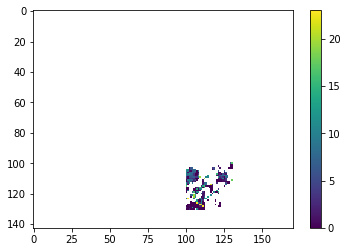

In [65]:
% matplotlib inline
print(np.nanmean(big_training_res - sml_training_res))
imshow(big_training_res - sml_training_res)
plt.colorbar()

In [55]:
change = (big_training_res - sml_training_res)[100:131,100:131]
change

array([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,   1.25,  11.5 ],
       [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,   0.  ,   0.  ],
       [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,   1.25,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,   0.  ,   0.  ],
       [   nan,    nan,   0.  ,   0.  ,   0.  ,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           na

# Cut Stuff
This is left over code from my attempts to speed up the change detection process. I managed to vectorize quite a lot of the process, but it was slower than the original version, so it is saved here in case someone else wants to have a look.

## function: vectorMode

In [60]:
def vectorMode(pixeldata, column, span):
    
    heirarchy = {1: 1, 2: 4, 3: 2, 4: 3} # class to priority, vegetation > earth > water > urban
    reversedheirarchy = {1: 1, 2: 3, 3: 4, 4:2} # priority to class
     
    # create sequential group numbers with a group size = span
    pixeldata['group'] = np.arange(len(pixeldata)) // span
    # create new dataframe with group numbers as index and the mode of each group as the data.
    # will make heirarchical index if more than 1 mode
    groups = pixeldata.groupby('group').apply(pd.DataFrame.mode)
    # make new column with the group modes mapped according to heirarchy
    groups['mapped'] = groups[column].map(heirarchy)
    # unstack heirarchical index
    groups = groups['mapped'].unstack(level=-1)
    # find the lowest priority number (highest priority) for each group
    groups['lowest_priority'] = groups.min(axis = 1)
    # remap priority rankings to landcover classes
    groups['mode'] = groups['lowest_priority'].map(reversedheirarchy)
    # join the highest priority landcover mode for each group back onto the main data table
    pixeldata = pd.merge(pixeldata, groups[['mode']], how = 'left', left_on='group', right_index = True)
    # NaNify so that only every span rows have a value
    pixeldata.loc[(np.arange(len(pixeldata)) % span != 0),'mode'] = np.nan
    
    return pixeldata['mode']

## changeDetector vectorMode

In [61]:
def changeDetector(study_area, data, clftype):
    """description of current decision rule for assigning urban change:
     calculate the mode over each 10 scenes, and assign that value to the first scene of the 10
        if the first two modal values are both urban, assume already developed and move to next pixel
        if not, calculate the mode of the modes, over each 3 modes, assigning the value to the first
     find the first mode of modes that is urban for that pixel
        use that data (MOM_change date) to find the group of 3 modes that contributed to the mode of modes
        within the individual classifications for that pixel within that group of 30 classifications
           if there is an instance of 2 classifications in a row being urban, use the date of the first of those
           if not, simply use the first instance of an urban pixel in that range of 30

    Ideas for improvement:
       - Deal with water pixels (eg if >25% of classifications are water, ignore)

    Limitations of Method:
       - Many of them!
       - Algorithm needs first 20 to establish baseline - so it can't detect early change
       - Algorithm needs last 30 to build mode of modes - so it can't detect most recent change """

    # setting up the results raster
    shape = data.shape
    changedates_arr = np.zeros((shape[1], shape[0]), dtype=np.float32)
    changedates_arr[changedates_arr == 0] = np.nan

    # variables for the modal filtering
    mode_span = 10
    MoM_span = 3

    start = datetime.datetime.now()
    print('Change detection for ' + study_area + ' start time: ' + str(start))

    # a very slow nested loop, keen to remove if possible
#     for x in range(shape[0]):
#         for y in range(shape[1]): 
    for x in range(100,131,1):
        for y in range(100,131,1):
            
            # make a dataframe of the time-series of the predicted classifications
            pixeldata = pd.DataFrame(data[x, y, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])
    
            # remove any rows with NaNs
            pixeldata = pixeldata[~np.isnan(pixeldata['predicted_landcover'])]

            # remove any possibility of duplicate dates (based on an issue with swmelbourne study area)
            pixeldata = pixeldata[~pixeldata.index.duplicated(keep = 'first')]

            # calculate mode of each group of 10 rows
            pixeldata['mode1'] = vectorMode(pixeldata, 'predicted_landcover', 10)

            # if either of the first two modes are urban, assume pixel is already urban at start of landsat archive 
            if (pixeldata[~np.isnan(pixeldata['mode1'])].iloc[0:2].values ==  2).any():
                continue

            # view or slice of data with modes
            modes = pixeldata[~np.isnan(pixeldata['mode1'])]

            # third level of nested of loops :(
            # applying modal filter to the modes, to create mode of modes
            # save the result in the pixeldata dataframe
            pixeldata['mode_of_modes'] = vectorMode(pixeldata[['mode1']],'mode1', 3)

            # decision criteria
            if len(pixeldata[pixeldata['mode_of_modes'] == 2]) > 0:
                MoM_changedate = pixeldata[pixeldata['mode_of_modes'] == 2].iloc[0].name
                M_ss = pixeldata.loc[MoM_changedate::]
                M_changedate = M_ss[M_ss['mode1'] == 2].iloc[0].name
                M_changedate_loc = pixeldata.index.get_loc(M_changedate)
                pix_ss = pixeldata.iloc[M_changedate_loc - mode_span : M_changedate_loc + mode_span]
                twoinarow = pix_ss[(pix_ss['predicted_landcover'] == pix_ss['predicted_landcover'].shift(-1)) & 
                                    (pix_ss['predicted_landcover'][pix_ss['predicted_landcover'] == 2])]
                if len(twoinarow) > 0:
                    changedate = twoinarow.iloc[0].name
                else:
                    changedate = pix_ss[pix_ss['predicted_landcover'] == 2].iloc[0].name
                changedates_arr[y, x] = dateStringToFloat(changedate)

    # print how long the modal filtering and change detection took                
    print(study_area + ' processing time: ' + str(datetime.datetime.now() - start))           

    # save the results to a .pkl for future access
    results_save_location = '../' + study_area + '/changeresults_' + clftype + '_Vector_allTD.pkl'
    changedates_arr.dump(results_save_location)  
    print('Results have been saved to', results_save_location, '\n')
    return changedates_arr

## applyChangeDetector

In [23]:
def applyChangeDetector(obj):
    """
            description of current decision rule for assigning urban change:
             calculate the mode over each 10 scenes, and assign that value to the first scene of the 10
                if the first two modal values are both urban, assume already developed and move to next pixel
                if not, calculate the mode of the modes, over each 3 modes, assigning the value to the first
             find the first mode of modes that is urban for that pixel
                use that data (MOM_change date) to find the group of 3 modes that contributed to the mode of modes
                within the individual classifications for that pixel within that group of 30 classifications
                   if there is an instance of 2 classifications in a row being urban, use the date of the first of those
                   if not, simply use the first instance of an urban pixel in that range of 30

            Ideas for improvement:
               - Deal with water pixels (eg if >25% of classifications are water, ignore)

            Limitations of Method:
               - Many of them!
               - Algorithm needs first 20 to establish baseline - so it can't detect early change
               - Algorithm needs last 30 to build mode of modes - so it can't detect most recent change
               - It's very slow - mulitple nested loops. Main speed up would come from being able to do
                  Modal filter as a df.apply(modalFilter)"""
#     print(obj.xy.values)
    # make a DataFrame of the data to work with
    pixeldata = pd.DataFrame(obj.values, index = obj.date.values, columns = ['predicted_landcover'])

    # drop any rows with nulls
    pixeldata = pixeldata.dropna(axis = 0, how='any')  
    # drop any duplicates
    pixeldata = pixeldata[~pixeldata.index.duplicated(keep = 'first')]
    
    # variables for the modal filtering
    mode_span = 10
    MoM_span = 3

    # calculate mode of each group of 10 rows
    pixeldata['mode1'] = vectorMode(pixeldata, 'predicted_landcover', mode_span)

    # if either of the first two modes are urban, assume pixel is already urban at start of landsat archive 
    if (pixeldata[~np.isnan(pixeldata['mode1'])].iloc[0:2].values ==  2).any():
        changedate = np.nan
#         print("branch 1")
        return xr.DataArray([changedate], dims = 'xy')

    # view or slice of data with modes
    modes = pixeldata[~np.isnan(pixeldata['mode1'])]

    pixeldata['mode_of_modes'] = vectorMode(modes[['mode1']],'mode1', MoM_span)
    
    # decision criteria
    if len(pixeldata[pixeldata['mode_of_modes'] == 2]) > 0:
        MoM_changedate = pixeldata[pixeldata['mode_of_modes'] == 2].iloc[0].name
        M_ss = pixeldata.loc[MoM_changedate::]
        M_changedate = M_ss[M_ss['mode1'] == 2].iloc[0].name
        M_changedate_loc = pixeldata.index.get_loc(M_changedate)        
#         print('MoM change', MoM_changedate)
#         print('M_changedate: ' + M_changedate + ' location ' + str(M_changedate_loc))

        pix_ss = pixeldata.iloc[M_changedate_loc - mode_span : M_changedate_loc + mode_span]
#         print(pix_ss)
        twoinarow = pix_ss[(pix_ss['predicted_landcover'] == pix_ss['predicted_landcover'].shift(-1)) & 
                            (pix_ss['predicted_landcover'][pix_ss['predicted_landcover'] == 2])]
#         print('twoinarow')
#         print(twoinarow)
#         print(pixeldata.iloc[M_changedate_loc - mode_span : M_changedate_loc + mode_span])
        if len(twoinarow) > 0:
#             print("branch 2")
#             changedate = twoinarow.iloc[0].name
            changedate = dateStringToFloat(twoinarow.iloc[0].name)
            
        else:
#             print("branch 3")
            changedate = dateStringToFloat(pix_ss[pix_ss['predicted_landcover'] == 2].iloc[0].name)
    else:
#         print("branch 4")
        changedate =  np.nan
        
#     print(changedate)
    return xr.DataArray([changedate], dims = 'xy')

In [91]:
data[105:107,74:76,:].stack(xy = ('x','y')).sel(band='predicted_landcover').groupby('xy').apply(applyChangeDetector).unstack(dim='xy')

# data[105:107,74:76,:].sel(band='predicted_landcover').reduce(applyChangeDetector, axis = 2)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()